# SSF 训练log分享与可视化脚本
路径层级为：
output/<MODEL_TYPE>/<DATASET_MISSION>/<DATASET_NAME>/<METHOD_NAME>/<EXACT_TRAINING>


In [1]:
import csv
import os
import sys
import pandas
import numpy as np

## VTAB LOGS

VTAB任务路径：

SSF/output/vit_base_patch16_224_in21k/vtab/

具体任务路径组成：

...vtab/<单个数据集>/<方法名>/<训练日志文件夹>/summary.csv


SSF/output/vit_base_patch16_224_in21k/vtab/caltech101/ssf/20230522-115426-vit_base_patch16_224_in21k-224/summary.csv

### 加载Log文件：

In [2]:
# 
LOG_DIR="/data/PEFT/output/"
LOG_DIR="/data/work_dirs/PEFT/"
LOG_DIR="/media/disk1/wyh/SSF/"
PAPER_RESULT={
    "caltech101":92.6,
    "dsprites_loc":77.3,
    "cifar_100":69.0,
    "clevr_dist":62.3,
    "dsprites_ori":54.9,
    "clevr_count":75.9,
    "dmlab":53.3,
    "diabetic_retinopathy":75.5,
    "dtd":75.1,
    "patch_camelyon":87.4,
    "eurosat":95.9,
    "pets":91.8,
    "kitti":80.6,
    "flowers102":99.4,
    "resisc45":87.4,
    "svhn":90.2,
    "smallnorb_azi":29.5,
    "smallnorb_ele":37.9,
    "sun397":52.9,
}
method_name="ssf"
method_name="linear_probe"
log_path="vit_base_patch16_224_in21k/vtab"
# csv.reader(open(sys.argv[1], 'r'), delimiter=',')
# List all files in a directory using scandir()
basepath = os.path.join(LOG_DIR,log_path)
ssf_log_dict_vtab={}

with os.scandir(basepath) as datasets:
    for dataset in datasets:
        print(dataset.name)
        if dataset.is_dir():
            with os.scandir(dataset) as methods:
                for method in methods:
                    # print(method.name)
                    if method.is_dir() and method.name==method_name:
                        ssf_log_dict_vtab[dataset.name]=[]
                        with os.scandir(method) as runs:
                            for run in runs:
                                print("\t",run.name)
                                if run.is_dir():
                                    with os.scandir(run) as files:
                                        for file in files:
                                            if file.name.endswith(".csv"):
                                                # print(file.name)
                                                with open(file, newline='') as csvfile:
                                                    reader = csv.reader(csvfile, delimiter=',')
                                                    # Use pandas to load data.
                                                    df = pandas.read_csv(file,header=0)
                                                    # df=df.astype(float)
                                                    # epoch,train_loss,eval_loss,eval_top1,eval_top5
                                                    df=df.loc[df["epoch"]!="epoch"]
                                                    # print(df)
                                                    df["epoch"]=df["epoch"].astype(int)
                                                    df["train_loss"]=df["train_loss"].astype(float)
                                                    df["eval_loss"]=df["eval_loss"].astype(float)
                                                    df["eval_top1"]=df["eval_top1"].astype(float)
                                                    df["eval_top5"]=df["eval_top5"].astype(float)
                                                    ssf_log_dict_vtab[dataset.name].append(df)
                                                    
        

cifar_100
	 20230607-163428-vit_base_patch16_224_in21k-224
svhn
	 20230607-231609-vit_base_patch16_224_in21k-224
resisc45
	 20230607-224916-vit_base_patch16_224_in21k-224
caltech101
	 20230607-144435-vit_base_patch16_224_in21k-224
	 20230607-162856-vit_base_patch16_224_in21k-224
flowers102
	 20230607-195122-vit_base_patch16_224_in21k-224
clevr_dist
	 20230607-165332-vit_base_patch16_224_in21k-224
clevr_count
	 20230607-164200-vit_base_patch16_224_in21k-224
kitti
	 20230607-162628-vit_base_patch16_224_in21k-224
dsprites_ori
	 20230607-185925-vit_base_patch16_224_in21k-224
sun397
	 20230608-001632-vit_base_patch16_224_in21k-224
patch_camelyon
	 20230607-221523-vit_base_patch16_224_in21k-224
dmlab
	 20230607-175338-vit_base_patch16_224_in21k-224
dsprites_loc
	 20230607-181101-vit_base_patch16_224_in21k-224
smallnorb_azi
	 20230607-234407-vit_base_patch16_224_in21k-224
eurosat
	 20230607-195100-vit_base_patch16_224_in21k-224
dtd
	 20230607-194834-vit_base_patch16_224_in21k-224
smallnorb_el

### 提取最佳表现进行比较

give the highest performance of every dataset.

csv formed like :

epoch,train_loss,eval_loss,eval_top1,eval_top5

0,6.497406005859375,6.088685486522025,0.6903353057199211,4.35568704799474


In [3]:
trials=len(ssf_log_dict_vtab["caltech101"])
# for dn,dfs in ssf_log_dict_vtab.items():
print("Results of VTAB: in {}".format(trials))
print("Ave\tPaper\tDrop\tBest\tvar\tDataset")
runed={}
avg_mean,all_max_mean=0,0
for dn,dfs in ssf_log_dict_vtab.items():
    runed[dn]=len(dfs)
    # print(dn)
    # print(dn, type(df["eval_top1"].max()))
    maxes=np.array([df["eval_top1"].max() for df in dfs])
    # print(dn,":",maxes)
    all_max=maxes.max()
    all_max_mean+=all_max
    avg,var=maxes.mean(),maxes.var()
    avg_mean+=avg
    # printed float only keep 3 decimal places
    print("{:.3f}\t{}\t{:.3f}\t{:.3f}\t{:.3f}\t{}".format(avg, \
        PAPER_RESULT[dn],avg-PAPER_RESULT[dn], all_max ,var,dn))
all_max_mean/=len(ssf_log_dict_vtab)
avg_mean/=len(ssf_log_dict_vtab)
pmean=np.array(list(PAPER_RESULT.values())).mean()
print("{:.3f}\t{:.1f}\t{:.3f}\t{:.3f}\t{:.3f}\t{}".format(avg_mean, \
    pmean,avg_mean-pmean,all_max_mean,0,"ALL"))


Results of VTAB: in 2
Ave	Paper	Drop	Best	var	Dataset
61.620	69.0	-7.380	61.620	0.000	cifar_100
44.015	90.2	-46.185	44.015	0.000	svhn
82.794	87.4	-4.606	82.794	0.000	resisc45
90.508	92.6	-2.092	90.894	0.149	caltech101
99.187	99.4	-0.213	99.187	0.000	flowers102
39.093	62.3	-23.207	39.093	0.000	clevr_dist
46.273	75.9	-29.627	46.273	0.000	clevr_count
63.483	80.6	-17.117	63.483	0.000	kitti
27.791	54.9	-27.109	27.791	0.000	dsprites_ori
50.768	52.9	-2.132	50.768	0.000	sun397
81.934	87.4	-5.466	81.934	0.000	patch_camelyon
39.844	53.3	-13.456	39.844	0.000	dmlab
24.707	77.3	-52.593	24.707	0.000	dsprites_loc
16.922	29.5	-12.578	16.922	0.000	smallnorb_azi
34.407	95.9	-61.493	34.407	0.000	eurosat
72.074	75.1	-3.026	72.074	0.000	dtd
28.486	37.9	-9.414	28.486	0.000	smallnorb_ele
89.646	91.8	-2.154	89.646	0.000	pets
75.203	75.5	-0.297	75.203	0.000	diabetic_retinopathy
56.250	73.1	-16.850	56.271	0.000	ALL


In [4]:
# find which is not runed
print("Not runed:")
for key in PAPER_RESULT.keys():
    if key not in runed.keys():
        print(key)

Not runed:


### 合并log里的loss数据：

np.savetxt("eval_losses.csv", eval_losses, delimiter=",")
np.savetxt("train_losses.csv", train_losses, delimiter=",")

In [5]:
# title,eval_losses,train_losses=[],[],[]
# for dn,dfs in ssf_log_dict_vtab.items():
#     title.append(dn)
#     eval_losses.extend([[dn,*list(df["eval_loss"])] for df in dfs])
#     train_losses.extend([[dn,*list(df["train_loss"])] for df in dfs])
# # list save to csv
# with open("eval_losses.csv", "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerows(eval_losses)
# with open("train_losses.csv", "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerows(train_losses)


### Train loss + eval loss 作图

每个数据集一个子图

<Figure size 640x480 with 0 Axes>

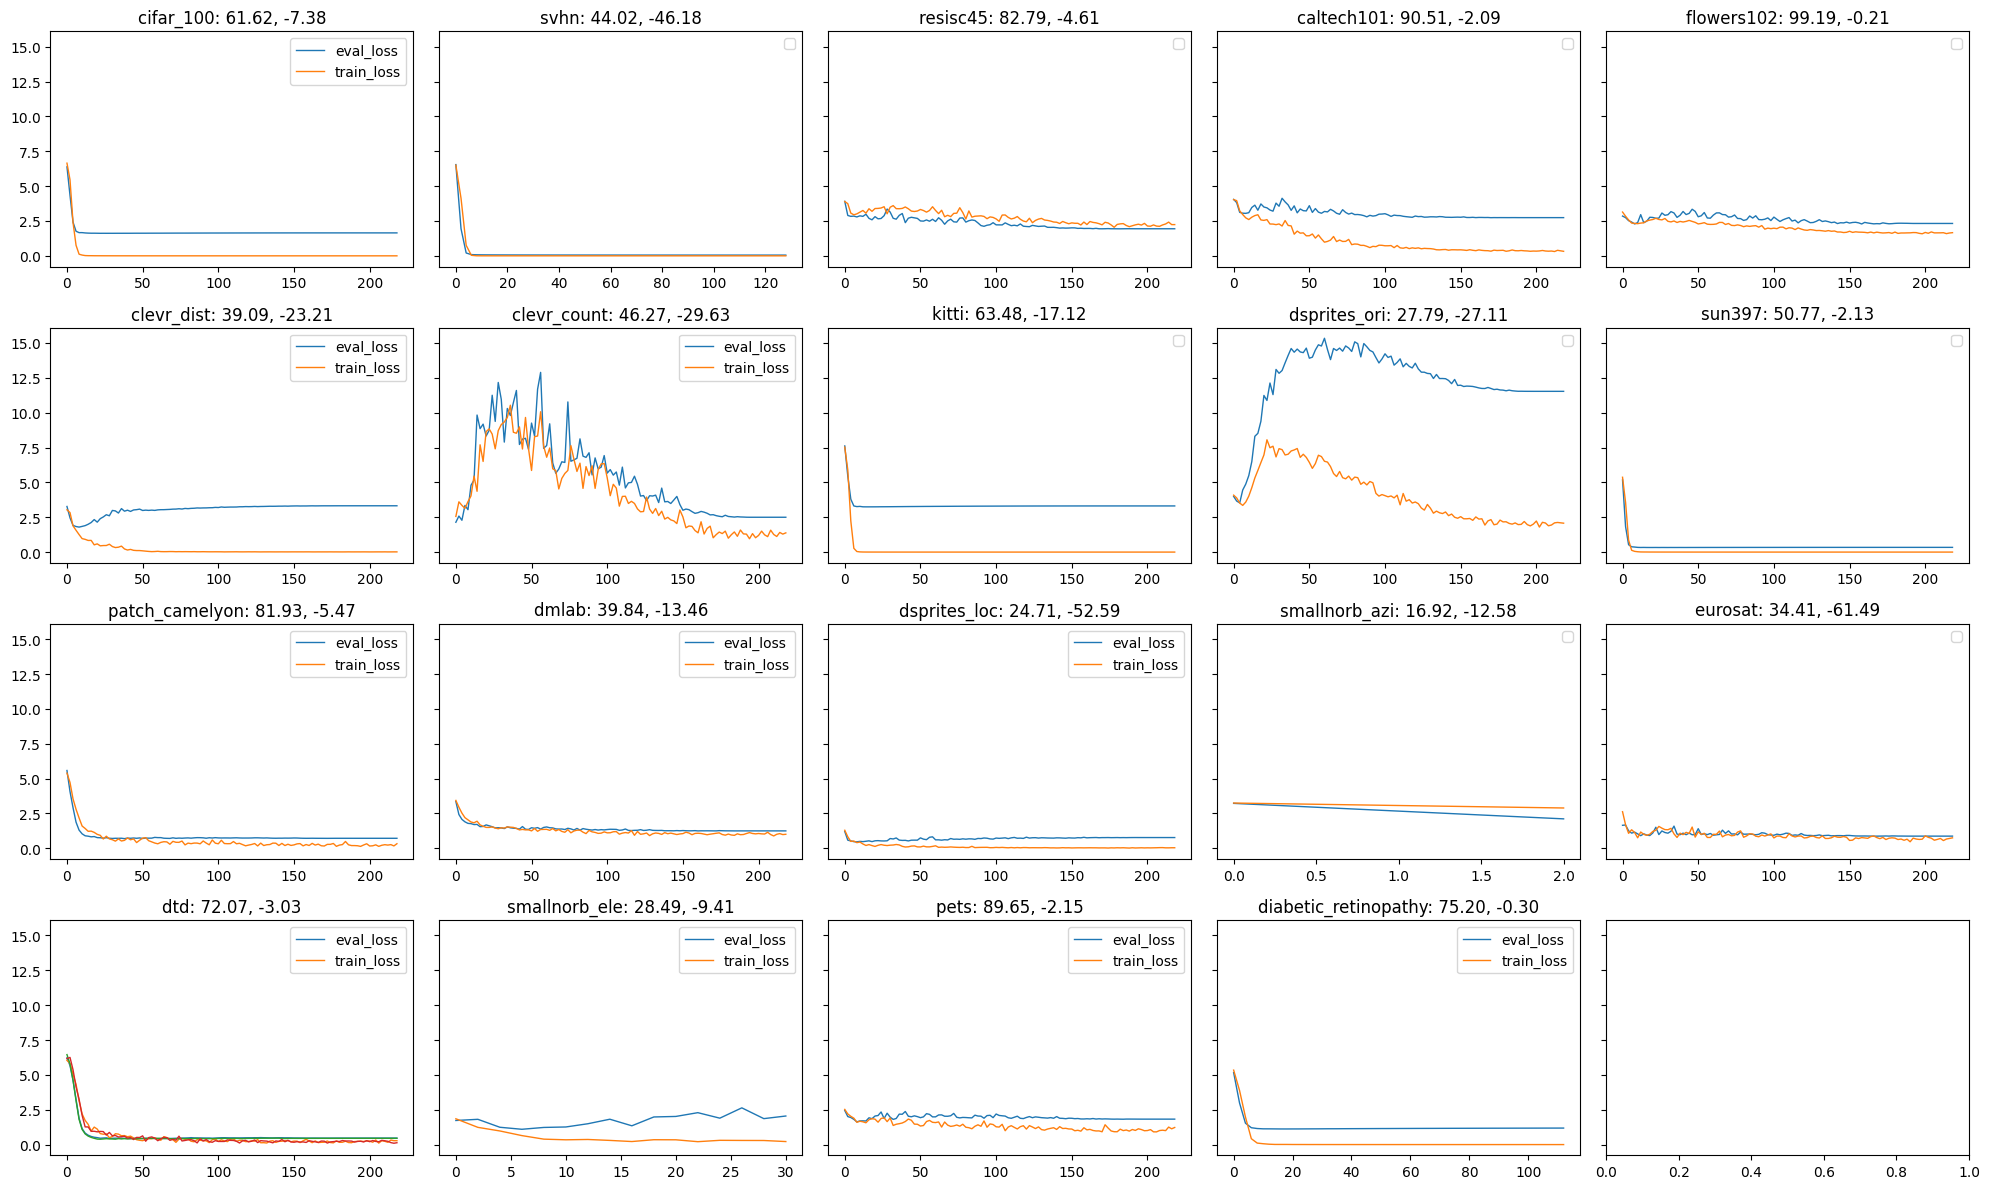

In [6]:
import warnings
warnings. filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.models as models

row=4
subp_num=len(ssf_log_dict_vtab)
col=int(np.ceil(subp_num/row))
plt.clf()
fig, axs = plt.subplots(ncols=col, nrows=row, sharey='all')#,gridspec_kw={"hspace": 0, "wspace": 0})
fig.set_size_inches(20, 12)

for i,(dn,dfs) in enumerate(ssf_log_dict_vtab.items()):
    line_num=len(dfs)*2
    eloss=[df["eval_loss"] for df in dfs]
    tloss=[df["train_loss"] for df in dfs]
    # plot subplot line chart
    assert len(eloss) == len(tloss)
    for j in range(len(eloss)):
        axs[i%4,i//4].plot(eloss[j],linewidth=1)
        axs[i%4,i//4].plot(tloss[j],linewidth=1)
    # # plot mean line
    # axs[i//col,i%col].set_xticks([])
    # axs[i].set_xlabel(f"{i+1}")
    maxes=np.array([df["eval_top1"].max() for df in dfs])
    all_max=maxes.max()
    avg,var=maxes.mean(),maxes.var()
    # label="{}: avg {:.3f} max {:.3f}".format(dn,avg,all_max)
    label="{}: {:.2f}, {:.2f}".format(dn,avg,avg-PAPER_RESULT[dn])
    axs[i//col,i%col].set_title(label)
    # add legend
    axs[i//col,i%col].legend([f"eval_loss",f"train_loss"],loc='upper right')
    # axs[i//col,i%col].legend()
# sns.set_style('white')
# sns.set(style='whitegrid')
# sns.despine(right=True,left=True)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
# plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout()
# plt.savefig("losses.png",dpi=300)
plt.show()


## FULL CIFAR100 / IMAGENET1K LOGS

CIFAR100/ImageNet1k任务路径：

SSF/output/vit_base_patch16_224_in21k/cifar_100/

具体任务路径组成：

...cifar_100/<方法名>/<训练日志文件夹>/summary.csv


SSF/output/vit_base_patch16_224_in21k/vtab/caltech101/ssf/20230522-115426-vit_base_patch16_224_in21k-224/summary.csv


In [10]:
# 
PAPER_RESULT={
    "cifar_100":93.99,
    "imagenet_1k":83.10,
}
method_name="linear_probe"
cifar_log_path="./vit_base_patch16_224_in21k/"
# csv.reader(open(sys.argv[1], 'r'), delimiter=',')
# List all files in a directory using scandir()
basepath = os.path.join(LOG_DIR,cifar_log_path)
ssf_log_dict_cifar={}
dataset_names=["cifar_100",]
with os.scandir(basepath) as datasets:
    for dataset in datasets:
        print(dataset.name)
        if dataset.is_dir() and dataset.name in dataset_names:
            with os.scandir(dataset) as methods:
                for method in methods:
                    # print(method.name)
                    if method.is_dir() and method.name==method_name:
                        ssf_log_dict_cifar[dataset.name]=[]
                        with os.scandir(method) as runs:
                            for run in runs:
                                print("\t",run.name)
                                if run.is_dir():
                                    with os.scandir(run) as files:
                                        for file in files:
                                            if file.name.endswith(".csv"):
                                                # print(file.name)
                                                with open(file, newline='') as csvfile:
                                                    reader = csv.reader(csvfile, delimiter=',')
                                                    # Use pandas to load data.
                                                    df = pandas.read_csv(file)
                                                    # df=df.astype(float)
                                                    # epoch,train_loss,eval_loss,eval_top1,eval_top5
                                                    df["epoch"]=df["epoch"].astype(int)
                                                    df["train_loss"]=df["train_loss"].astype(float)
                                                    df["eval_loss"]=df["eval_loss"].astype(float)
                                                    df["eval_top1"]=df["eval_top1"].astype(float)
                                                    df["eval_top5"]=df["eval_top5"].astype(float)
                                                    ssf_log_dict_cifar[dataset.name].append(df)
                                                    
        

cifar_100
	 20230608-123712-vit_base_patch16_224_in21k-224
	 20230607-111826-vit_base_patch16_224_in21k-224
	 20230608-140745-vit_base_patch16_224_in21k-224
	 20230607-111714-vit_base_patch16_224_in21k-224
	 20230608-140909-vit_base_patch16_224_in21k-224
	 20230608-113003-vit_base_patch16_224_in21k-224
	 20230608-124134-vit_base_patch16_224_in21k-224
cifar100_mlp
vtab


In [11]:
# give the highest performance of every dataset.
# csv formed like :
# epoch,train_loss,eval_loss,eval_top1,eval_top5
# 0,6.497406005859375,6.088685486522025,0.6903353057199211,4.35568704799474
# print("Results of CIFAR10 \\ ImageNet:")
# print("Repro\tPaper\tave\tvar\tDataset")
# for dn,dfs in ssf_log_dict_cifar.items():
#     # print(dn)
#     maxes=np.array([df["eval_top1"].max() for df in dfs])
#     all_max=maxes.max()
#     avg,var=maxes.mean(),maxes.var()
#     # printed float only keep 3 decimal places
#     print("{:.3f}\t{}\t{:.3f}\t{:.3f}\t{:.3f}\t{}".format(all_max, \
#         PAPER_RESULT[dn],all_max-PAPER_RESULT[dn],avg,var,dn))
    
trials=len(ssf_log_dict_cifar["cifar_100"])
print("Results of CIFAR100: in {}".format(trials))
print("Ave\tPaper\tDrop\tBest\tvar\tDataset")
mean=0
for dn,dfs in ssf_log_dict_cifar.items():
    # print(dn)
    # print(dn, type(df["eval_top1"].max()))
    maxes=np.array([df["eval_top1"].max() for df in dfs])
    # remove low performance that is lower than 90%
    maxes=maxes[maxes>75]
    # print(dn,":",maxes)
    all_max=maxes.max()
    mean+=all_max
    avg,var=maxes.mean(),maxes.var()
    # printed float only keep 3 decimal places
    print("{:.3f}\t{}\t{:.3f}\t{:.3f}\t{:.3f}\t{}".format(avg, \
        PAPER_RESULT[dn],avg-PAPER_RESULT[dn], all_max ,var,dn))
mean/=len(ssf_log_dict_cifar)
pmean=np.array(list(PAPER_RESULT.values())).mean()
# print("{:.3f}\t{:.1f}\t{:.3f}\t{:.3f}\t{:.3f}\t{}".format(mean, \
#     pmean,mean-pmean,mean,0,"ALL"))

Results of CIFAR100: in 7
Ave	Paper	Drop	Best	var	Dataset
88.578	93.99	-5.412	88.930	0.044	cifar_100


In [9]:
LOG_DIR="/media/disk1/wyh/SSF/"
PAPER_RESULT={
    "cifar100_mlp":88.70,
}
method_name="cifar100_mlp"
log_path="vit_base_patch16_224_in21k"
# csv.reader(open(sys.argv[1], 'r'), delimiter=',')
# List all files in a directory using scandir()
basepath = os.path.join(LOG_DIR,log_path)
ssf_log_dict_cifar_mlp={}

with os.scandir(basepath) as datasets:
    for dataset in datasets:
        print(dataset.name)
        if dataset.is_dir() and dataset.name =="cifar100_mlp":
            with os.scandir(dataset) as runs:
                for run in runs:
                    print("\t",run.name)
                    if run.is_dir():
                        with os.scandir(run) as files:
                            for file in files:
                                if file.name.endswith(".csv"):
                                    # print(file.name)
                                    with open(file, newline='') as csvfile:
                                        reader = csv.reader(csvfile, delimiter=',')
                                        # Use pandas to load data.
                                        df = pandas.read_csv(file,header=0)
                                        # df=df.astype(float)
                                        # epoch,train_loss,eval_loss,eval_top1,eval_top5
                                        df=df.loc[df["epoch"]!="epoch"]
                                        # print(df)
                                        df["epoch"]=df["epoch"].astype(int)
                                        df["train_loss"]=df["train_loss"].astype(float)
                                        df["eval_loss"]=df["eval_loss"].astype(float)
                                        df["eval_top1"]=df["eval_top1"].astype(float)
                                        df["eval_top5"]=df["eval_top5"].astype(float)
                                        if ssf_log_dict_cifar_mlp.get(dataset.name) is None:
                                            ssf_log_dict_cifar_mlp[dataset.name]=[]
                                        ssf_log_dict_cifar_mlp[dataset.name].append(df)
# print(ssf_log_dict_cifar_mlp)
trials=len(ssf_log_dict_cifar_mlp["cifar100_mlp"])
print("Results of CIFAR100: in {}".format(trials))
print("Ave\tPaper\tDrop\tBest\tvar\tDataset")
mean=0
for dn,dfs in ssf_log_dict_cifar_mlp.items():
    # print(dn)
    # print(dn, type(df["eval_top1"].max()))
    maxes=np.array([df["eval_top1"].max() for df in dfs])
    # remove low performance that is lower than 90%
    maxes=maxes[maxes>75]
    # print(dn,":",maxes)
    all_max=maxes.max()
    mean+=all_max
    avg,var=maxes.mean(),maxes.var()
    # printed float only keep 3 decimal places
    print("{:.3f}\t{}\t{:.3f}\t{:.3f}\t{:.3f}\t{}".format(avg, \
        PAPER_RESULT[dn],avg-PAPER_RESULT[dn], all_max ,var,dn))
mean/=len(ssf_log_dict_cifar_mlp)
pmean=np.array(list(PAPER_RESULT.values())).mean()
# print("{:.3f}\t{:.1f}\t{:.3f}\t{:.3f}\t{:.3f}\t{}".format(mean, \
#     pmean,mean-pmean,mean,0,"ALL"))

cifar_100
cifar100_mlp
	 20230607-084550-vit_base_patch16_224_in21k-224
	 20230607-095755-vit_base_patch16_224_in21k-224
	 20230607-085244-vit_base_patch16_224_in21k-224
	 20230607-084653-vit_base_patch16_224_in21k-224
	 20230607-083546-vit_base_patch16_224_in21k-224
	 20230607-085321-vit_base_patch16_224_in21k-224
	 20230607-085846-vit_base_patch16_224_in21k-224
	 20230607-084816-vit_base_patch16_224_in21k-224
	 20230607-084443-vit_base_patch16_224_in21k-224
	 20230607-085047-vit_base_patch16_224_in21k-224
	 20230607-084402-vit_base_patch16_224_in21k-224
vtab
Results of CIFAR100: in 3
Ave	Paper	Drop	Best	var	Dataset
82.270	88.7	-6.430	84.090	3.312	cifar100_mlp
